# Malmquist Bias: Selection Bias for Astronomers

Author: Brad Lyke

In this notebook, I'll be describing my procedure for simulating the Malmquist bias around the code so it is easier to understand what I'm demonstrating. Results for each section will be summarized after the plots that accompany each section.

In [118]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)

Below are three subfunctions I wrote to generate the star sets that will be used for each $\sigma_M$ distribution. These also allow me to generate apparent magnitudes and absolute magnitudes as necessary.

In [119]:
def make_stars(N,r_inner,r_outer,M_mean,M_std):
    mag_temp = np.random.normal(M_mean,M_std,size=N)
    logri = np.log10(r_inner)
    logro = np.log10(r_outer)
    log_dist_temp = np.random.uniform(logri,logro,size=N)
    dist_temp = 10**(log_dist_temp)
    #dist_temp = np.random.uniform(r_inner,r_outer,size=N)
    
    return mag_temp,log_dist_temp,dist_temp

def app_mag(absMag,dist):
    return absMag + 5*np.log10(dist/10)

def abs_Mag(app_mag,dist):
    return app_mag - 5*np.log10(dist/10)

## Section I: Generating Stars

The code block below generates a set of stars for each $\sigma_M$ distribution. I used A0 stars, so the mean absolute magnitude of these stars, M_m, is 0. I decided on a total of $10^{6}$ stars for each distribution and used consecutive, concentric shells 5 pc thick, starting at 10 pc. The below code will generate the requisite number of stars per shell to ensure that the number density of stars, $\rho$ (or rho in the code), is 1 $\textrm{star}$ $\textrm{pc}^{-3}$. In the last shell it will only generate up to the last of the $10^{6}$ stars, so it will have a smaller number than expected. Each shell has a Gaussian distribution of absolute magnitudes within the shell, but each star within a shell is assigned a random distance from a Uniform distribution.

In [159]:
Num = 1000000
M_m = 0
M_sarr = np.array([0.1,0.3,0.5,1.0])
star_set10 = np.zeros(0,dtype=[('Mag','f4'),('logdist','f8'),('distance','f8'),('mag','f4'),('modulus','f8'),('r_inner','f8'),('r_outer','f8')])
star_set01 = np.zeros(0,dtype=[('Mag','f4'),('logdist','f8'),('distance','f8'),('mag','f4'),('modulus','f8'),('r_inner','f8'),('r_outer','f8')])
star_set03 = np.zeros(0,dtype=[('Mag','f4'),('logdist','f8'),('distance','f8'),('mag','f4'),('modulus','f8'),('r_inner','f8'),('r_outer','f8')])
star_set05 = np.zeros(0,dtype=[('Mag','f4'),('logdist','f8'),('distance','f8'),('mag','f4'),('modulus','f8'),('r_inner','f8'),('r_outer','f8')])
for j in range(4):
    M_s = M_sarr[j]
    num_check = 1000000
    r_temp = 10
    r_step = 5 #parsecs
    r_0 = 10 #parsecs
    rho = 1 #1 star per parsec
    i = 0
    while num_check > 0:
        r_outer_temp = r_temp + r_step
        num_in_chunk = int((float(4)/3) * np.pi*rho*(r_outer_temp**(3)-r_temp**(3))) +1
        if num_in_chunk > num_check:
            num_in_chunk = num_check
        star_settemp = np.zeros(num_in_chunk,dtype=[('Mag','f4'),('logdist','f8'),('distance','f8'),('mag','f4'),('modulus','f8'),('r_inner','f8'),('r_outer','f8')])
        star_settemp['Mag'],star_settemp['logdist'],star_settemp['distance'] = make_stars(num_in_chunk,r_temp,r_outer_temp,M_m,M_s)
        star_settemp['mag'] = app_mag(star_settemp['Mag'],star_settemp['distance'])
        star_settemp['r_inner'],star_settemp['r_outer'] = r_temp,r_outer_temp
        if j == 0:
            star_set01 = np.append(star_set01,star_settemp)
        elif j == 1:
            star_set03 = np.append(star_set03,star_settemp)
        elif j == 2:
            star_set05 = np.append(star_set05,star_settemp)
        elif j == 3:
            star_set10 = np.append(star_set10,star_settemp)
        #print(r_temp,r_outer_temp,num_in_chunk,num_check)
        #print(star_set10[i:i+num_in_chunk])
        r_temp = r_outer_temp
        i = num_in_chunk
        num_check = num_check - num_in_chunk

## Section II: Star Statistics

The below block of code generates four overlayed histograms of the absolute magnitude of the all of the stars in each distribution generated in Section I. Each distribution has a separate color as seen in the legend. While each shell was itself a Gaussian, the sum of Gaussian distributions is also a Gaussian distribution.

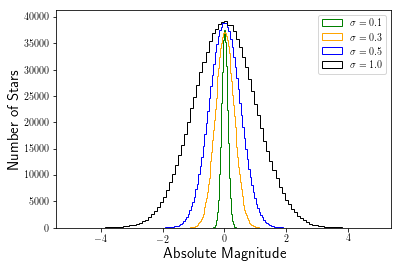

In [126]:
plt.hist(star_set01['Mag'],bins=100,histtype='step',color='green',label=r'$\sigma = 0.1$');
plt.hist(star_set03['Mag'],bins=100,histtype='step',color='orange',label=r'$\sigma = 0.3$');
plt.hist(star_set05['Mag'],bins=100,histtype='step',color='blue',label=r'$\sigma = 0.5$');
plt.hist(star_set10['Mag'],bins=100,histtype='step',color='black',label=r'$\sigma = 1.0$');
plt.legend(loc = 'upper right')
plt.xlabel('Absolute Magnitude',fontsize=15);
plt.ylabel('Number of Stars',fontsize=15);

The below code block will create bins within each shell, with a distance assigned by the center distance of the shell. It counts the number of stars in each shell.

In [127]:
bin_centers = np.array([12.5,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5])
bin_edges = np.array([10,15,20,25,30,35,40,45,50,55,60,65])
num_in_bins01 = np.zeros(11,dtype='i4')
num_in_bins03 = np.zeros(11,dtype='i4')
num_in_bins05 = np.zeros(11,dtype='i4')
num_in_bins10 = np.zeros(11,dtype='i4')
for i in range(11):
    win01 = np.where((star_set01['distance']>=bin_edges[i])&(star_set10['distance']<bin_edges[i+1]))[0]
    win03 = np.where((star_set03['distance']>=bin_edges[i])&(star_set10['distance']<bin_edges[i+1]))[0]
    win05 = np.where((star_set05['distance']>=bin_edges[i])&(star_set10['distance']<bin_edges[i+1]))[0]
    win10 = np.where((star_set10['distance']>=bin_edges[i])&(star_set10['distance']<bin_edges[i+1]))[0]
    num_in_bins01[i] = len(win01)
    num_in_bins03[i] = len(win03)
    num_in_bins05[i] = len(win05)
    num_in_bins10[i] = len(win10)

Below we see the plot for $\log(N)$, the number of stars per bin against the $\log(D)$, or the log of the distance to each bin center.

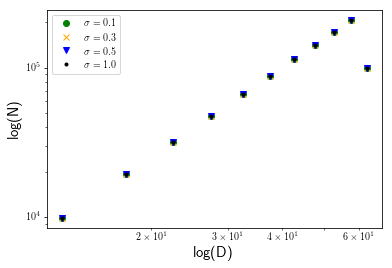

In [129]:
plt.loglog(bin_centers,num_in_bins01,marker='o',linestyle='',color='green',label=r'$\sigma = 0.1$');
plt.loglog(bin_centers,num_in_bins03,marker='x',linestyle='',color='orange',label=r'$\sigma = 0.3$');
plt.loglog(bin_centers,num_in_bins05,marker='v',linestyle='',color='blue',label=r'$\sigma = 0.5$');
plt.loglog(bin_centers,num_in_bins10,marker='.',linestyle='',color='black',label=r'$\sigma = 1.0$');
plt.legend()
plt.xlabel('log(D)',fontsize=15);
plt.ylabel('log(N)',fontsize=15);

### Results (Section II)

As we can see, the last bin has fewer stars than expected only because I imposed an arbitrary limit of $10^{6}$ stars total for each distribution. However, it is clear that as distance increases the number of stars also increases in a linear fashion (on a log-log plot).

## Section III: Apparent Magnitude Cuts

In the below code blocks I chose an apparent magnitude cut that would remove some of the stars in each distribution. Due to the distance/apparent magnitude relationship, the number of visible stars is less than the number of actual stars. If assumptions are made about a star population and compared to apparent magnitude data, a bias will appear as the apparent magnitude cut preferentially selects the brightest stars are far distances. Because I wanted the cut to be noticeable over ranges of 65 pc (the maximum range of the stars), I chose an unrealistic apparent magnitude cutoff of 4, apcut in the code below.

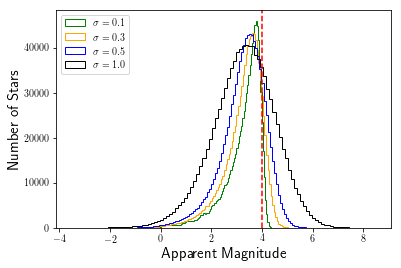

In [133]:
apcut = 4 #Apparent magnitude cut
plt.hist(star_set01['mag'],bins=100,histtype='step',color='green',label=r'$\sigma = 0.1$');
plt.hist(star_set03['mag'],bins=100,histtype='step',color='orange',label=r'$\sigma = 0.3$');
plt.hist(star_set05['mag'],bins=100,histtype='step',color='blue',label=r'$\sigma = 0.5$');
plt.hist(star_set10['mag'],bins=100,histtype='step',color='black',label=r'$\sigma = 1.0$');
plt.legend(loc = 'upper left')
plt.axvline(x=apcut,color='red',linestyle='--')
plt.xlabel('Apparent Magnitude',fontsize=15);
plt.ylabel('Number of Stars',fontsize=15);

Above is a plot of apparent magnitude for the total star set in each distribution against the apparent magnitude cut. As can be seen, the same magnitude cut for different $\sigma_M$ causes different relative percentages of stars to be selected. The Gaussian distributions are also skewed slightly due to the distance/apparent magnitude relationship. The star sets were generated with a symmetrical Gaussian in absolute magnitude, so the apparent magnitude is skewed by the randomly assigned distances within each shell.

Below I make the apparent magnitude cut on the stars in each distribution and then plot what the new distributions of absolute magnitude look like.

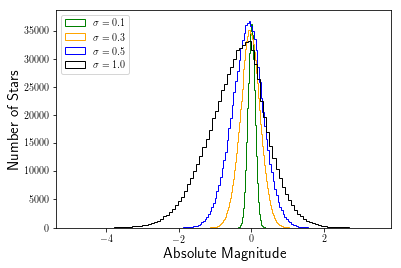

In [137]:
wcut01 = np.where(star_set01['mag']<apcut)[0]
wcut03 = np.where(star_set03['mag']<apcut)[0]
wcut05 = np.where(star_set05['mag']<apcut)[0]
wcut10 = np.where(star_set10['mag']<apcut)[0]
star_set01_cut = star_set01[wcut01]
star_set03_cut = star_set03[wcut03]
star_set05_cut = star_set05[wcut05]
star_set10_cut = star_set10[wcut10]
plt.hist(star_set01_cut['Mag'],bins=100,histtype='step',color='green',label=r'$\sigma = 0.1$');
plt.hist(star_set03_cut['Mag'],bins=100,histtype='step',color='orange',label=r'$\sigma = 0.3$');
plt.hist(star_set05_cut['Mag'],bins=100,histtype='step',color='blue',label=r'$\sigma = 0.5$');
plt.hist(star_set10_cut['Mag'],bins=100,histtype='step',color='black',label=r'$\sigma = 1.0$');
plt.legend(loc = 'upper left');
plt.xlabel('Absolute Magnitude',fontsize=15);
plt.ylabel('Number of Stars',fontsize=15);

Above we can more clearly see the skewing effect of the apparent magnitude cut on the different distributions of stars.

Below I plotted the Absolute magnitude of the star distributions against their distance. Each distribution is plotted separately so that each full population of leftover stars is visible. Colors and marker symbols remain constant throughout the notebook.

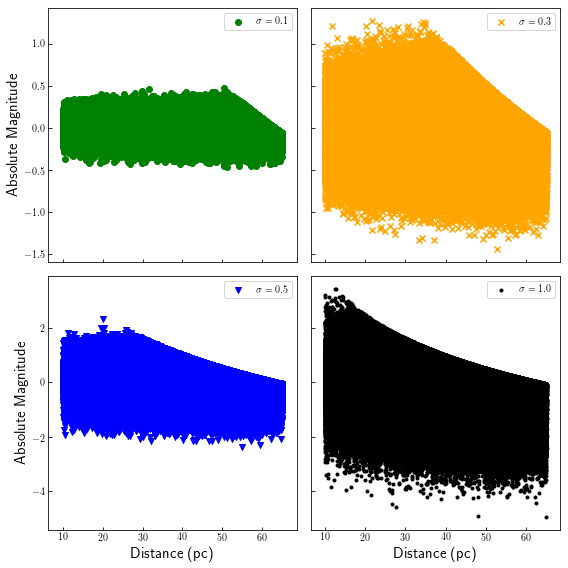

In [153]:
fig0,axes = plt.subplots(nrows=2,ncols=2,sharey='row',sharex='col',figsize=(8,8))
axes[0,0].scatter(star_set01_cut['distance'],star_set01_cut['Mag'],marker='o',color='green',label=r'$\sigma = 0.1$');
axes[0,0].tick_params(axis='both',direction='in');
axes[0,0].legend(loc='upper right');
axes[0,1].scatter(star_set03_cut['distance'],star_set03_cut['Mag'],marker='x',color='orange',label=r'$\sigma = 0.3$');
axes[0,1].tick_params(axis='both',direction='in');
axes[0,1].legend(loc='upper right');
axes[1,0].scatter(star_set05_cut['distance'],star_set05_cut['Mag'],marker='v',color='blue',label=r'$\sigma = 0.5$');
axes[1,0].tick_params(axis='both',direction='in');
axes[1,0].legend(loc='upper right');
axes[1,1].scatter(star_set10_cut['distance'],star_set10_cut['Mag'],marker='.',color='black',label=r'$\sigma = 1.0$');
axes[1,1].tick_params(axis='both',direction='in');
axes[1,1].legend(loc='upper right');
axes[1,0].set_xlabel('Distance (pc)',fontsize=15);
axes[1,1].set_xlabel('Distance (pc)',fontsize=15);
axes[0,0].set_ylabel('Absolute Magnitude',fontsize=15);
axes[1,0].set_ylabel('Absolute Magnitude',fontsize=15);
plt.tight_layout()

As we can see from above, the apparent magnitude cut had less of an effect on the tight distributions than on the looser distributions.

Below I rebin the Magnitude data against the same bin centers are before (centered in each shell). In each bin I calculated a new mean absolute magnitude per bin, $\langle M \rangle _{\textrm{sample}}$ and subtracted the true mean from these (which is 0, due to the A0 star population.) These are plotted against distance.

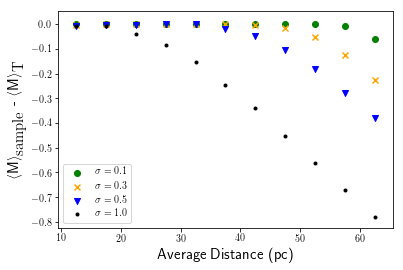

In [148]:
mag_sample01 = np.zeros(11,dtype='f8')
mag_sample03 = np.zeros(11,dtype='f8')
mag_sample05 = np.zeros(11,dtype='f8')
mag_sample10 = np.zeros(11,dtype='f8')
for i in range(11):
    wset01 = np.where((star_set01_cut['distance']>=bin_edges[i])&(star_set01_cut['distance']<bin_edges[i+1]))[0]
    wset03 = np.where((star_set03_cut['distance']>=bin_edges[i])&(star_set03_cut['distance']<bin_edges[i+1]))[0]
    wset05 = np.where((star_set05_cut['distance']>=bin_edges[i])&(star_set05_cut['distance']<bin_edges[i+1]))[0]
    wset10 = np.where((star_set10_cut['distance']>=bin_edges[i])&(star_set10_cut['distance']<bin_edges[i+1]))[0]
    temp_mags01 = star_set01_cut[wset01]
    temp_mags03 = star_set03_cut[wset03]
    temp_mags05 = star_set05_cut[wset05]
    temp_mags10 = star_set10_cut[wset10]
    mag_sample01[i] = np.mean(temp_mags01['Mag'])
    mag_sample03[i] = np.mean(temp_mags03['Mag'])
    mag_sample05[i] = np.mean(temp_mags05['Mag'])
    mag_sample10[i] = np.mean(temp_mags10['Mag'])

plt.scatter(bin_centers,mag_sample01,marker='o',color='green',label=r'$\sigma = 0.1$');
plt.scatter(bin_centers,mag_sample03,marker='x',color='orange',label=r'$\sigma = 0.3$');
plt.scatter(bin_centers,mag_sample05,marker='v',color='blue',label=r'$\sigma = 0.5$');
plt.scatter(bin_centers,mag_sample10,marker='.',color='black',label=r'$\sigma = 1.0$');
plt.legend(loc='lower left');
plt.xlabel('Average Distance (pc)',fontsize=15);
plt.ylabel(r'${\langle}$M${\rangle}$$_{\textrm{sample}}$ - ${\langle}$M${\rangle}$$_{\textrm{T}}$',fontsize=15);

### Results: Section III

Above we can see that as the distance increases the average magnitude difference increases (negative magnitudes are brighter). This means that brighter stars are preferentially selected, but assumed to be of the same distribution as before. This causes an error in distance calculations, making these stars appear closer than they actually are (which in turn causes our estimates of star volume density to increase). These incorrect distances actually affect a large number of further assumptions and calculations as well.

## Section IV: The Second Parameter

In the below code I start by assuming there is a simple second parameter, P, that can be used to estimate absolute magnitude independent of distance. As such, I use the same magnitude-cut sets from Section III, but assign each star an $M_{\textrm{est}}$ that is dependent on P, their true absolute magnitude, and a random Gaussian offset. I chose an arbitrary value for P.

In [149]:
P = -2
b01 = np.random.normal(0,0.01,size=len(star_set01_cut))
b03 = np.random.normal(0,0.03,size=len(star_set03_cut))
b05 = np.random.normal(0,0.05,size=len(star_set05_cut))
b10 = np.random.normal(0,0.1,size=len(star_set10_cut))
star_set_2param01 = star_set01_cut['Mag'] * P + b01
star_set_2param03 = star_set03_cut['Mag'] * P + b03
star_set_2param05 = star_set05_cut['Mag'] * P + b05
star_set_2param10 = star_set10_cut['Mag'] * P + b10

Below I created took the difference between each star's absolute magnitude and this estimated M, with the function $M - M_{\textrm{est}}$. I plotted this difference, for each distribution again, against the distance.

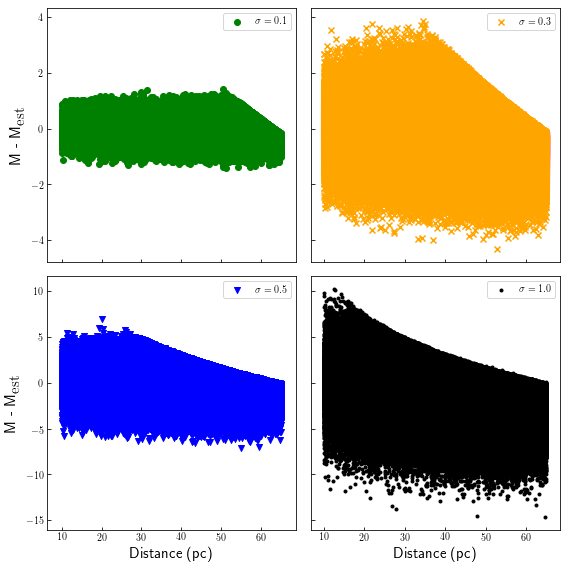

In [156]:
star_set_2diff01 = star_set01_cut['Mag'] - star_set_2param01
star_set_2diff03 = star_set03_cut['Mag'] - star_set_2param03
star_set_2diff05 = star_set05_cut['Mag'] - star_set_2param05
star_set_2diff10 = star_set10_cut['Mag'] - star_set_2param10

fig1,axes1 = plt.subplots(nrows=2,ncols=2,sharey='row',sharex='col',figsize=(8,8))
axes1[0,0].scatter(star_set01_cut['distance'],star_set_2diff01,marker='o',color='green',label=r'$\sigma = 0.1$');
axes1[0,0].tick_params(axis='both',direction='in');
axes1[0,0].legend(loc='upper right');
axes1[0,1].scatter(star_set03_cut['distance'],star_set_2diff03,marker='x',color='orange',label=r'$\sigma = 0.3$');
axes1[0,1].tick_params(axis='both',direction='in');
axes1[0,1].legend(loc='upper right');
axes1[1,0].scatter(star_set05_cut['distance'],star_set_2diff05,marker='v',color='blue',label=r'$\sigma = 0.5$');
axes1[1,0].tick_params(axis='both',direction='in');
axes1[1,0].legend(loc='upper right');
axes1[1,1].scatter(star_set10_cut['distance'],star_set_2diff10,marker='.',color='black',label=r'$\sigma = 1.0$');
axes1[1,1].tick_params(axis='both',direction='in');
axes1[1,1].legend(loc='upper right');
axes1[1,0].set_xlabel('Distance (pc)',fontsize=15);
axes1[1,1].set_xlabel('Distance (pc)',fontsize=15);
axes1[0,0].set_ylabel(r'M - M$_{\textrm{est}}$',fontsize=15);
axes1[1,0].set_ylabel(r'M - M$_{\textrm{est}}$',fontsize=15);
plt.tight_layout()

As can be seen above, this magnitude difference did not change with distance, meaning that the value for $M_{\textrm{est}}$ is independent of distance. These are uncorrelated as the cuts are due to the reduced sample space I used from Section III.

After completing this I also plotted these differences against the difference between absolute magnitude of each star and the true mean absolute magnitude (which is still 0). As such, I plotted $M - M_{\textrm{est}}$ (y) against $M - \langle M \rangle _{\textrm{T}}$ (x), where $\langle M \rangle _{\textrm{T}} = 0$.

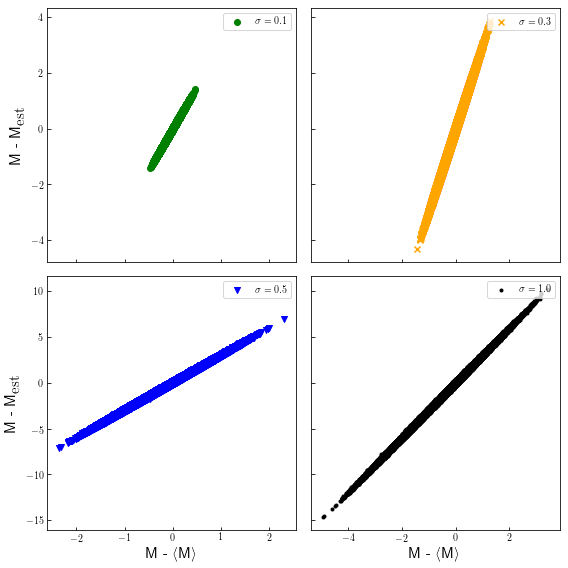

In [158]:
#plt.scatter(star_set10_cut['Mag'],star_set_wtfb)
fig2,axes2 = plt.subplots(nrows=2,ncols=2,sharey='row',sharex='col',figsize=(8,8))
axes2[0,0].scatter(star_set01_cut['Mag'],star_set_2diff01,marker='o',color='green',label=r'$\sigma = 0.1$');
axes2[0,0].tick_params(axis='both',direction='in');
axes2[0,0].legend(loc='upper right');
axes2[0,1].scatter(star_set03_cut['Mag'],star_set_2diff03,marker='x',color='orange',label=r'$\sigma = 0.3$');
axes2[0,1].tick_params(axis='both',direction='in');
axes2[0,1].legend(loc='upper right');
axes2[1,0].scatter(star_set05_cut['Mag'],star_set_2diff05,marker='v',color='blue',label=r'$\sigma = 0.5$');
axes2[1,0].tick_params(axis='both',direction='in');
axes2[1,0].legend(loc='upper right');
axes2[1,1].scatter(star_set10_cut['Mag'],star_set_2diff10,marker='.',color='black',label=r'$\sigma = 1.0$');
axes2[1,1].tick_params(axis='both',direction='in');
axes2[1,1].legend(loc='upper right');
axes2[1,0].set_xlabel(r'M - ${\langle}$M${\rangle}$',fontsize=15);
axes2[1,1].set_xlabel(r'M - ${\langle}$M${\rangle}$',fontsize=15);
axes2[0,0].set_ylabel(r'M - M$_{\textrm{est}}$',fontsize=15);
axes2[1,0].set_ylabel(r'M - M$_{\textrm{est}}$',fontsize=15);
plt.tight_layout()

### Results: Section IV

As can be seen, there is a linear relationship between the difference and the absolute magnitude, where the slope of this line is P, or -2. With this estimator for absolute magnitude, independent of distance, we can make better assumptions about star populations.

## Final Results

The Malmquist bias is a simple selection bias for astronomy due to the convolved nature of apparent magnitude with distance. We do not live in a "perfect" universe and therefore have limits on what brightness we can detect. This leads to us, invariably, not seeing certain stars at certain distances. As long as we understand that we are seeing only a selection of the brightest stars, we can make better predictions about apparent magnitude. However, if this relationship is not well understood we will calculate incorrect distances based on incorrect assumptions of a star population's absolute magnitude distribution.

To help offset this we need to seek a second parameter that is a good estimator of absolute magnitude independent of distance. In reality we can use star properties like color, metallicity, or spectra to help make these corrections. Armed with this second parameter we can better calculate absolute magnitudes and see that we have preferentially selected bright stars at far distances within our observational hard limits. This then allows us to realize we are seeing the bright stars and infer from what we can see what objects look like that we can see (though there is a host of other problems with these assumptions, like wheter isotropy and homogeneity are valid for example).

Overall we should have known there would be a selection bias, and we need to find a way to correct for it (or we already have).